# WSI 24L
## Ćwiczenie 2 - algorytm genetyczny, optymalizacja układu dróg i miejsc parkingowych
### Igor Szabłowski

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import choices
import seaborn as sns

In [2]:
class GeneticAlgorithm:

    def solve(self, pop0, q, pc, pm, t_max):
        t = 0
        best_route = []
        population = pop0
        population_values = [q(x) for x in pop0]
        value_best = np.max(population_values)
        x_best = population[np.argmax(population_values)]
        while t < t_max:
            population = self._selection(population, population_values)
            population = self._crossover(population, pc)
            population = self._mutation(population, pm)
            population_values = [q(x) for x in population]
            new_population_value_best = np.max(population_values)
            if new_population_value_best > value_best:
                x_best = population[np.argmax(population_values)]
                value_best = new_population_value_best
            t += 1
            best_route.append(value_best)
        return x_best, value_best, best_route

    def _selection(self, population, population_values):
        values_sum = np.sum(population_values)
        pi_values = [value/values_sum for value in population_values]
        return choices(population, pi_values, k=len(population))
    
    def _crossover(self, population, pc):
        population_after_crossover = []
        while population:
            random_chance = np.random.random()
            if random_chance <= pc:
                crossover_point = np.random.choice(len(population[0])-1)
                first_parent_population = population.pop(0)
                second_parent_population = population.pop(0)
                first_child_population = np.array(list(first_parent_population[:crossover_point]) + list(second_parent_population[crossover_point:]))
                second_child_population = np.array(list(second_parent_population[:crossover_point]) + list(first_parent_population[crossover_point:]))
                population_after_crossover.append(first_child_population)
                population_after_crossover.append(second_child_population)
            else:
                population_after_crossover.append(population.pop(0))
                population_after_crossover.append(population.pop(0))
        return population_after_crossover

    def _mutation(self, population, pm):
        for index_x, x in enumerate(population):
            for index_gene, gene in enumerate(x):
                random_chance = np.random.random()
                if random_chance <= pm:
                    switched_gene = 1 if not gene else 0
                    population[index_x][index_gene] = switched_gene
        return population


def evaluate(x):
    n = int(len(x) ** (0.5))
    checked = [[False] * n for _ in range(n)]
    avaliable = [[False] * n for _ in range(n)]
    to_check = []
    for i in range(n):
        to_check.append((i, 0))
        to_check.append((i, n - 1))
        to_check.append((0, i))
        to_check.append((n - 1, i))
    while to_check:
        i, j = to_check.pop()
        if checked[i][j]:
            continue
        checked[i][j] = True
        if x[i * n + j]:
            avaliable[i][j] = True
        else:
            if i > 0:
                to_check.append((i - 1, j))
            if i < n - 1:
                to_check.append((i + 1, j))
            if j > 0:
                to_check.append((i, j - 1))
            if j < n - 1:
                to_check.append((i, j + 1))
    return sum(sum(row) for row in avaliable)


In [3]:
def prepare_for_heatmap(x):
    n = int(len(x) ** (0.5))
    checked = [[False] * n for _ in range(n)]
    avaliable = [[0.5 if gene else 0 for gene in x_row] for x_row in np.array(x).reshape((n, n))]
    to_check = []
    for i in range(n):
        to_check.append((i, 0))
        to_check.append((i, n - 1))
        to_check.append((0, i))
        to_check.append((n - 1, i))
    while to_check:
        i, j = to_check.pop()
        if checked[i][j]:
            continue
        checked[i][j] = True
        if x[i * n + j]:
            avaliable[i][j] = 1
        else:
            if i > 0:
                to_check.append((i - 1, j))
            if i < n - 1:
                to_check.append((i + 1, j))
            if j > 0:
                to_check.append((i, j - 1))
            if j < n - 1:
                to_check.append((i, j + 1))
    return avaliable

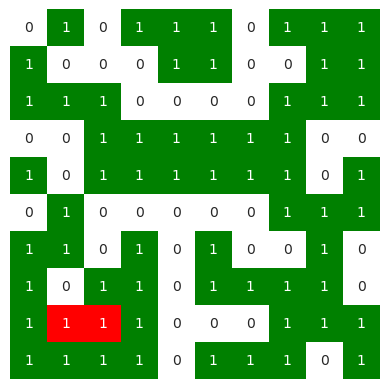

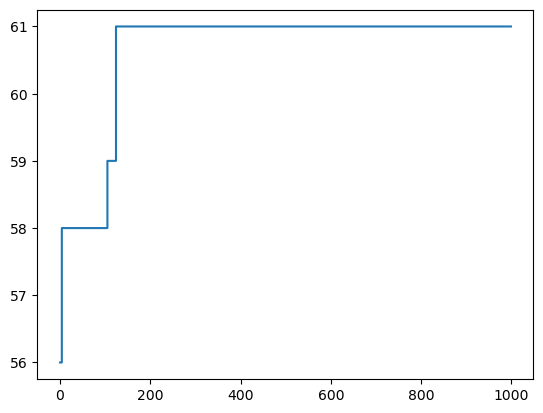

In [4]:
x = np.random.randint(0, 2, (1000, 100))
solver = GeneticAlgorithm()
t_max = 1000

x, values, best_route = solver.solve(x, evaluate, 0.99, 0.05, t_max)
x_data = prepare_for_heatmap(x)
sns.heatmap(x_data, annot=np.array(x).reshape((10, 10)), cmap=['white', 'red', 'green'], cbar=False, square=True, xticklabels='', yticklabels='')

plt.show()
plt.step(np.arange(t_max), best_route)
plt.show()



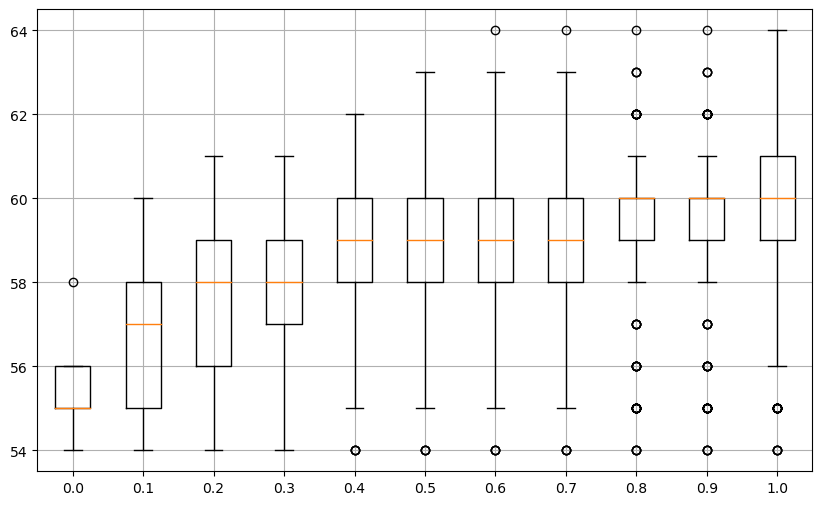

In [5]:
solver = GeneticAlgorithm()
t_max = 1000
pc_array = np.arange(0, 1.01, 0.1)
results_x = []
result = []
for pc in pc_array:
    for _ in range(25):
        x = np.random.randint(0, 2, (100, 100))
        x, values, best_route = solver.solve(x, evaluate, pc, 0.015, t_max)
        results_x.append((x, values))
    result_values = [result_x[1] for result_x in results_x]
    result.append(result_values)
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.boxplot(result)
plt.xticks(np.arange(1, 12), np.round(pc_array, 1))
plt.show()


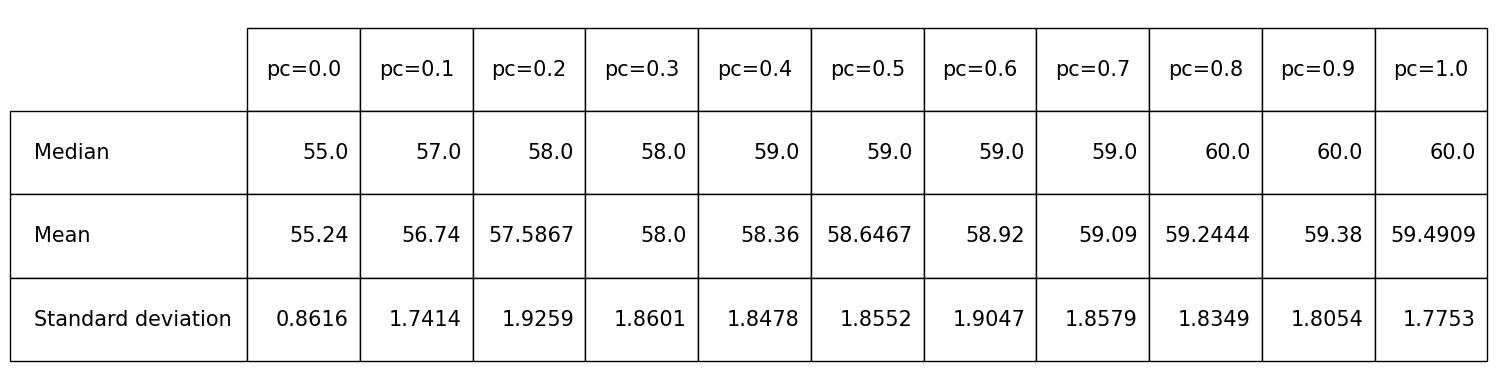

In [6]:
row_labels = ['Median', "Mean", 'Standard deviation']
column_labels = [f'pc={np.round(pc, 1)}' for pc in pc_array]
median = [np.median(values) for values in result]
mean = [np.mean(values) for values in result]
std_dev = [np.std(values) for values in result]
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=[median, np.round(mean, 4), np.round(std_dev, 4)], rowLabels=row_labels, colLabels=column_labels, loc='center')
table.set_fontsize(15)
table.scale(2.5, 5)
plt.show()